# Project Evaluation Criteria

## Data Loading and Preprocessing (2 points max)
- Load the data from the CSV files using the appropriate data import methods in PyTorch.
- Apply dataset splits that enable you to assess network overfitting.
- Preprocess the categorical and numerical data accordingly (refer to **Lesson 5 – Training Practices and Regularization** and **Lesson 6 – PyTorch in Production**).
- Make data loading protocols for mini-batch training.

## Approach and Methodology (2 points max)
- Implement a neural network architecture suited to the task and justify your choice (refer to **Lesson 6 – PyTorch in Production**).
- Apply regularization techniques that help prevent network overfitting.

## Results and Evaluation (2 points max)
- Build a training protocol to train your neural network on the dataset with a user-specified number of epochs.
- Implement methods that effectively regulate the training process (refer to **Lab 5 – Training Practices and Regularization**).
- Provide visualizations, if useful, that give an indication of the training procedure (e.g., a loss curve). These visualizations can be included in your report as part of your submission package.
- Implement a software method that saves the network’s weight with the best performance.  
  - These network weights should be saved as `.pt` / `.pth` file.
  - Include them as part of your submission package so that the teacher and the teaching assistant can reproduce your results. 

## Code Quality and Reproducibility (2 points max)
- Your code should be clean, well-structured, and properly commented.
- Ensure the code runs in inference mode with your network weights (`.pt` / `.pth` file) to produce the target variable (the number of rings) using the data from `test.csv`.
- Ensure that the model generates predictions for the number of rings for every data point in the test set.
- Write a `README` file for running your code in inference mode to produce the targets.  
  - This will help the teacher and the teaching assistant reproduce your results. 

## Summary and Justification (2 points max)
- Clearly summarize the key novelties of your approach.
- Justify the choices made in the data preprocessing, neural network design, training protocol, and inference protocol.
- Discuss any challenges encountered and potential improvements.

## Importing the data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

We will choose to use standardization because it includes the variance of the score. As we can see from the data ranges there may be outliers. And outliers may affect the the score a lot when we use the normalization route. We will only do this for the numerical columns and not the categorical column "Sex".

### Load and initiate the data

To prevent clutter we have moved the loading of the data to the file data_load.py. The loading of the data should not change because the data stays constant. All of  the other functions could change, therefore we leave them in the notebooks for easier change of functions. 

In [ ]:
from data_load import AbalonDataset


class AbalonDataset(Dataset):
    def __init__(self, data_df, train_dataset: "AbalonDataset" = None):
        """if train_dataset is provided, then it is assumed that this dataset must be the test dataset. We then access the mean and std of the provided dataset"""
        self.data = data_df
        #standardized_data = 
        if train_dataset is None:
            # We only want to split train and val set when the provided dataset is the train dataset so not the test dataset 
            # we only want to calculate the mean and std based on the train set
            self.mean = self.get_mean(self.data)
            self.std = self.get_std(self.data)
        else:
            self.mean = train_dataset.mean
            self.std = train_dataset.std
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        """we first take the row, then we pop Rings and Sex. Then we make a sex tensor which is a category, 
        then we make tensors of the numerical columns. We combine the sex and numerical into features. We also make a tensor of the dependent variable: Rings"""
        row = self.preprocess_data(self.data.iloc[index])
        target_col = None
        if "Rings" in row:
            target_col = row.pop("Rings")
        sex_feature = row.pop("Sex")
        # we make the sex tensor separate because it must be onehot encoded
        sex_tensor = torch.nn.functional.one_hot(torch.tensor(sex_feature, dtype=torch.long), num_classes=3).to(torch.float32)
        numerical_tensor = torch.tensor(row, dtype=torch.float32)
        # standardize the numerical features
        standardized_numerical_tensor = (numerical_tensor - self.mean) / (4* self.std)
        features = torch.concat([sex_tensor, standardized_numerical_tensor])

        # when target_col is none, the data is training or validation data
        if target_col is not None:
            target = torch.tensor(target_col, dtype=torch.float32).view(1)
        # in case the dataset is the test dataset where there is no Rings column, we need to create an empty target
        else:
            target = torch.tensor([0])
        return features, target

    @staticmethod
    def preprocess_data(row):
        """preproces data of sex to numerical values"""
        sex_map = {"M": 0, "F": 1, "I": 2}
        row = row.copy()
        row["Sex"] = sex_map[row["Sex"]]
        return row
    
    @staticmethod
    def get_mean(df):
        data = df.drop(["Sex", "Rings"], axis=1)
        return torch.tensor(data.mean().values, dtype=torch.float32)
    
    @staticmethod
    def get_std(df):
        data = df.drop(["Sex", "Rings"], axis=1)
        return torch.tensor(data.std().values, dtype=torch.float32)
    
    @classmethod
    def create_train_test_val(cls, csv_file_name, train_dataset: "AbalonDataset" = None):
        """class method to create a train test and val object of the AbalonDataset"""
        data = pd.read_csv(f"data/{csv_file_name}")
        if train_dataset is None:
            train_df, val_df = train_test_split(data, test_size = 0.2)
            trainAbalone = cls(train_df)
            valAbalone = cls(val_df, trainAbalone)
            return trainAbalone, valAbalone
        else:
            return cls(data, train_dataset)

def load_data(batch_size):

    train_dataset, test_dataset = AbalonDataset.create_train_test_val("train.csv")
    val_dataset = AbalonDataset.create_train_test_val("test.csv", train_dataset)

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(test_dataset, batch_size=batch_size)
    test_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader



## Setup model
We setup the model with two hidden layers and a Tanh activation function. 

In [ ]:
class AbaloneNetworkTwoLayer(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.Tanh(),            
            nn.Linear(num_hidden, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_outputs))

    def forward(self, x):
        return self.model(x)

## Setup the training cycle of the model

In [49]:
def l1_regularization(model, lambda_reg):
    l1_penalty = sum(param.abs().sum() for param in model.parameters())
    return lambda_reg * l1_penalty

def l2_regularization(model, lambda_reg):
    l2_penalty = sum(param.pow(2).sum() for param in model.parameters())
    return lambda_reg * l2_penalty

def train_model(model, train_loader, optimizer, device, criterion, val_loader, lambda_reg=None):
    model.train()
    train_loss = 0.0

    for inputs_load, targets_load in train_loader:
        inputs, targets = inputs_load.to(device), targets_load.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # only do regularization when lambda_reg has been passed to it.
        if lambda_reg is not None:
            loss += l2_regularization(model, lambda_reg)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)  # Compute average train loss

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
        

        
        val_loss /= len(val_loader)  # Compute average validation loss
    return train_loss, val_loss





## Plot the model results


In [5]:
def plot_figure(numepochs, trainlosses, vallosses):
    # Plot the loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, numepochs + 1), trainlosses, label="Train Loss", marker="o")
    plt.plot(range(1, numepochs + 1), vallosses, label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

## Train the complete model for its epochs

In [54]:
from statistics import mean
def train_setup_epochs(train_loader, val_loader, model, optimizer, device, criterion, num_epochs, lambda_reg=None, stop_converge = False):
    
    best_val_loss = float("inf")

    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loss, val_loss = train_model(model, train_loader, optimizer, device, criterion, val_loader, lambda_reg)
        train_losses.append(train_loss)
        val_losses.append(val_loss)


        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model, "best_model_running.pth")
            print("Saved Best Model")
        
        # if the mean of the previous three epochs is not improving anymore we stop. if improvement is less than 0.1% we stop
        if stop_converge:
            previous_3_epochs = val_losses[max(0, epoch-3): epoch]
            if previous_3_epochs:
                if val_loss *0.9999 > mean(previous_3_epochs):
                    print("model converged, it stopped improving at epoch: ", epoch)
                    break
    return train_losses, val_losses, epoch +1

## Run the model and training

We implement a two hidden layer neural network with 12 neurons. As from our experimentation this seemed to perform the best. THe hyperparameters of the optimizer have
- learning rate = 5e-3
- Weight decay = 1e-6
- momentum = 0.9

### Run model without regularization 

/Users/mehdigreefhorst/Desktop/DeepLearning1stAssignment-abalone/data_load.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_tensor = torch.tensor(row, dtype=torch.float32)


Epoch 1/100, Train Loss: 3.5629, Val Loss: 1.7498
Saved Best Model
Epoch 2/100, Train Loss: 1.7726, Val Loss: 1.6324
Saved Best Model
Epoch 3/100, Train Loss: 1.6778, Val Loss: 1.5564
Saved Best Model
Epoch 4/100, Train Loss: 1.6349, Val Loss: 1.5284
Saved Best Model
Epoch 5/100, Train Loss: 1.6024, Val Loss: 1.5150
Saved Best Model
Epoch 6/100, Train Loss: 1.6004, Val Loss: 1.5193
Epoch 7/100, Train Loss: 1.5818, Val Loss: 1.5149
Saved Best Model
Epoch 8/100, Train Loss: 1.5801, Val Loss: 1.5306
Epoch 9/100, Train Loss: 1.5609, Val Loss: 1.5138
Saved Best Model
Epoch 10/100, Train Loss: 1.5626, Val Loss: 1.5159
Epoch 11/100, Train Loss: 1.5528, Val Loss: 1.5241
Epoch 12/100, Train Loss: 1.5425, Val Loss: 1.5047
Saved Best Model
Epoch 13/100, Train Loss: 1.5323, Val Loss: 1.5189
Epoch 14/100, Train Loss: 1.5286, Val Loss: 1.5339
Epoch 15/100, Train Loss: 1.5404, Val Loss: 1.5223
Epoch 16/100, Train Loss: 1.5339, Val Loss: 1.5306
Epoch 17/100, Train Loss: 1.5306, Val Loss: 1.4920
Saved 

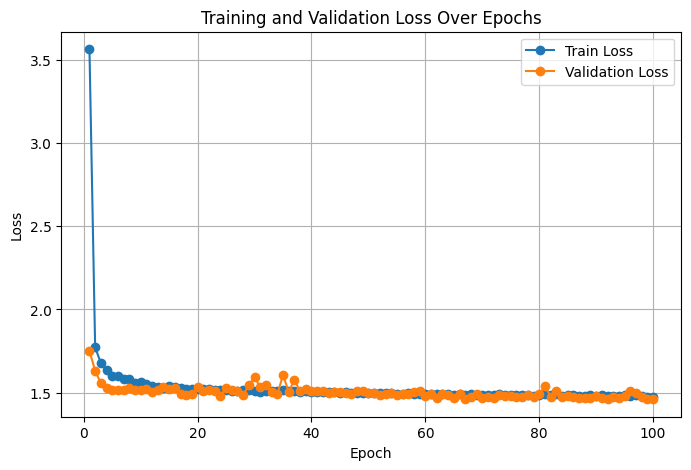

In [36]:
trainloader, valloader, testloader = load_data(batch_size=16)
model_abalone = AbaloneNetworkTwoLayer(10, 12, 1)
device = torch.device("cpu")
model_abalone.to(device)
criterion_l1 = nn.L1Loss()
optimizer_sgd = optim.SGD(model_abalone.parameters(), lr=5e-3, weight_decay=1e-6, momentum=0.9)
epochs = 100
train_loss_list, val_loss_list, epochs_done = train_setup_epochs(
    train_loader = trainloader,
    val_loader=valloader, 
    model=model_abalone, 
    optimizer=optimizer_sgd, 
    device=device, 
    criterion=criterion_l1, 
    num_epochs=epochs)

plot_figure(epochs_done, train_loss_list, val_loss_list)

### Run model with regularization

We choose to implement L1 regularization. As we are also using the L1 loss, so this seems like a smart choice. However we do not seem to worse results when L1 regularization is implemented, L2 regularization has also been explored but it yielded similar results the L1 regulurization. 

/Users/mehdigreefhorst/Desktop/DeepLearning1stAssignment-abalone/data_load.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_tensor = torch.tensor(row, dtype=torch.float32)


Epoch 1/100, Train Loss: 3.6412, Val Loss: 1.9657
Saved Best Model
Epoch 2/100, Train Loss: 1.7584, Val Loss: 1.9010
Saved Best Model
Epoch 3/100, Train Loss: 1.6511, Val Loss: 1.7512
Saved Best Model
Epoch 4/100, Train Loss: 1.6018, Val Loss: 1.7044
Saved Best Model
Epoch 5/100, Train Loss: 1.5813, Val Loss: 1.6685
Saved Best Model
Epoch 6/100, Train Loss: 1.5678, Val Loss: 1.6695
Epoch 7/100, Train Loss: 1.5643, Val Loss: 1.6297
Saved Best Model
Epoch 8/100, Train Loss: 1.5582, Val Loss: 1.6615
Epoch 9/100, Train Loss: 1.5539, Val Loss: 1.6575
Epoch 10/100, Train Loss: 1.5448, Val Loss: 1.6669
Epoch 11/100, Train Loss: 1.5456, Val Loss: 1.6352
Epoch 12/100, Train Loss: 1.5473, Val Loss: 1.6556
Epoch 13/100, Train Loss: 1.5396, Val Loss: 1.6038
Saved Best Model
Epoch 14/100, Train Loss: 1.5372, Val Loss: 1.6081
Epoch 15/100, Train Loss: 1.5368, Val Loss: 1.6201
Epoch 16/100, Train Loss: 1.5328, Val Loss: 1.6226
Epoch 17/100, Train Loss: 1.5275, Val Loss: 1.6083
Epoch 18/100, Train Los

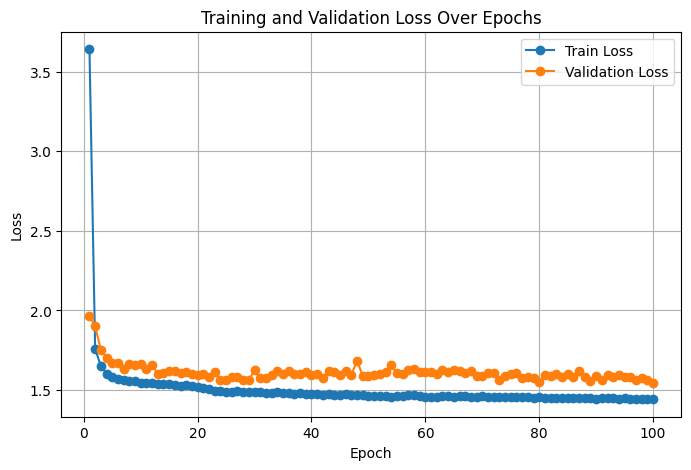

In [53]:
trainloader, valloader, testloader = load_data(batch_size=16)
model_abalone = AbaloneNetworkTwoLayer(10, 12, 1)
device = torch.device("cpu")
model_abalone.to(device)
criterion_l1 = nn.L1Loss()
optimizer_sgd = optim.SGD(model_abalone.parameters(), lr=5e-3, weight_decay=1e-6, momentum=0.9)
epochs = 100
lambda_reg_score = 1e-5
train_loss_list, val_loss_list, epochs_done = train_setup_epochs(train_loader = trainloader,
                                                    val_loader=valloader, 
                                                    model=model_abalone, 
                                                    optimizer=optimizer_sgd, 
                                                    device=device, 
                                                    criterion=criterion_l1, 
                                                    num_epochs=epochs,
                                                    lambda_reg=lambda_reg_score,
                                                    stop_converge=False)
plot_figure(epochs_done, train_loss_list, val_loss_list)

### Create final predictions of the final test.csv


In [ ]:
def create_predicted_csv(model_or_saved, test_loader, device):
    """if you set the model_or_saved to None or False, you use the torch pth file to load the model. You can also provide 
    model as parameter, then it will work based on the provided model"""
    if not model_or_saved:
        model = torch.load("best_model.pth", weights_only=False)
    else:
        model = model_or_saved
    model.eval()
    final_predictions = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            final_predictions.extend([round(float(output), 2) for output in outputs])
    
    final_df = pd.read_csv("data/test.csv")
    final_df["prediction"] = final_predictions
    final_df.to_csv("data/final.csv")
    final_df.to_markdown("final_test.md")

    return "correctly saved into final_test.csv the predictions + original data"

#print(create_predicted_csv(model_abalone, testloader))
print(create_predicted_csv(False, testloader, device))

correctly saved into final_test.csv the predictions + original data


# Notes for the report pdf

### The text below doesn't hava a place in the jupyter notebook so we add remarks during the process

A mistake was made initially where the weight decay was set to 1e4 instead of 1e-4, this led to a frustrating debugging session. The loss values were NaN, and it was hard to find it out. After checking the first couple of loss values. We saw that the loss became increasing exponentially larger, until it was so large that NaN was displayed. This is a great example of exploding gradients. 